In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Import our model implementations
from models.logistic import run_logistic_regression
from models.nnmodel import run_neural_network
from models.random_forest import run_random_forest
from models.decision_tree import run_decision_tree
from models.RBF_SVM import run_rbf_svm


In [2]:

def load_data(file_path, target_column=None):
    # Load the data
    try:
        data = pd.read_csv(file_path)
        print(f"Successfully loaded data with shape: {data.shape}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None
    
    # If target column is not specified, use the last column
    if target_column is None:
        X = data.iloc[:, :-1]
        y = data.iloc[:, -1]
    else:
        X = data.drop(target_column, axis=1)
        y = data[target_column]
        
    
    
    return X, y


In [3]:
def preprocess_data(X, y, test_size=0.2, random_state=42, scale=True):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    
    # Print data shape after initial splitting
    print(f"Initial split - X_train: {X_train.shape}, X_test: {X_test.shape}")
    # Scale numeric features if requested
    if scale:
        # Identify binary columns (starting with 'weather_' or 'sex_')
        binary_cols = [col for col in X_train.columns if col.startswith(('weather_', 'sex_'))]
        numeric_cols = [col for col in X_train.columns if col not in binary_cols]
        
        if len(numeric_cols) > 0:
            print(f"Scaling numeric columns: {numeric_cols}")
            scaler = StandardScaler()
            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
            
            X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
            X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
            
            X_train, X_test = X_train_scaled, X_test_scaled
    
    print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    # Print target column balance
    train_balance = pd.Series(y_train).value_counts(normalize=True)
    test_balance = pd.Series(y_test).value_counts(normalize=True)

    print("\nTarget column distribution:")
    print(f"Training set:\n{train_balance}")
    print(f"Testing set:\n{test_balance}")
    return X_train, X_test, y_train, y_test, X_test

In [4]:
def compare_models(X_train, X_test, y_train, y_test, models=['logistic']):
    results = {}
    model_objects = {}
    
    # Run models based on the list provided
    for model_name in models:
        if model_name.lower() == 'logistic':
            print("Running Logistic Regression...")
            logimodel, logimodel_results = run_logistic_regression(X_train, y_train, X_test, y_test)
            model_objects['logistic'] = logimodel
            results['logistic'] = logimodel_results
        elif model_name.lower() == 'nn':
            print("Running Neural Network...")
            nnmodel, nnmodel_results = run_neural_network(X_train, y_train, X_test, y_test)
            model_objects['nn'] = nnmodel
            results['nn'] = nnmodel_results
        elif model_name == 'rf':
            print("Running Random Forest...")
            rfmodel, rfmodel_results = run_random_forest(X_train, y_train, X_test, y_test)
            model_objects['rf'] = rfmodel
            results['rf'] = rfmodel_results
        elif model_name == 'dt':
            print("Running Decision Tree...")
            dtmodel, dtmodel_results = run_decision_tree(X_train, y_train, X_test, y_test)
            model_objects['dt'] = dtmodel
            results['dt'] = dtmodel_results
        elif model_name == 'rbf_svm':
            print("Running RBF SVM...")
            rbf_svm_model, rbf_svm_results = run_rbf_svm(X_train, y_train, X_test, y_test)
            model_objects['rbf_svm'] = rbf_svm_model
            results['rbf_svm'] = rbf_svm_results
        
    return results, model_objects


In [ ]:

def visualize_results(results):
    # Bar chart for accuracy, precision, recall, f1
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    models = list(results.keys())
    
    metrics_data = {metric: [results[model][metric] for model in models] for metric in metrics}
    # Print metrics for each model
    print("\n--- Model Performance Metrics ---")
    for model in models:
        print(f"\n{model.upper()} RESULTS:")
        for metric in metrics:
            print(f"{metric}: {results[model][metric]:.4f}")
        
        # Print additional metrics if available
        if 'accuracy' in results[model]:
            print(f"Accuracy: {results[model]['accuracy']:.4f}")
        if 'precision' in results[model]:
            print(f"Precision: {results[model]['precision']:.4f}")
        if 'recall' in results[model]:
            print(f"Recall: {results[model]['recall']:.4f}")
        if 'f1_score' in results[model]:
            print(f"F1 Score: {results[model]['f1_score']:.4f}")
        if 'confusion_matrix' in results[model]:
            print(f"Confusion Matrix:\n{results[model]['confusion_matrix']}")
            
    # Find the best model for each metric
    best_models = {}
    for metric in metrics:
        best_score = 0
        best_model = ""
        for model in models:
            if results[model][metric] > best_score:
                best_score = results[model][metric]
                best_model = model
        best_models[metric] = (best_model, best_score)

    # Print the best model for each metric
    print("\n--- Best Models ---")
    for metric, (model, score) in best_models.items():
        print(f"Best {metric}: {model} ({score:.4f})")
    # Create the plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    x = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(x + i*bar_width, metrics_data[metric], width=bar_width, label=metric)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + bar_width*1.5, models)
    plt.legend()
    plt.tight_layout()
    
    
    # For each model, plot confusion matrix
    for model_name, model_results in results.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(model_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()


In [ ]:

def main(data_path, target_column=None):
    # Load data
    X, y = load_data(data_path, target_column)
    
    if X is None or y is None:
        print("Failed to load data. Exiting.")
        return
    
    # Preprocess data
    X_train, X_test, y_train, y_test, x_test_with_horsename = preprocess_data(X, y)
    
    # Run models
    model_results, models = compare_models(X_train, X_test, y_train, y_test, models=['dt', 'logistic', 'rf', 'nn', 'rbf_svm']) #'nn',   , 'knn', 'nn_scikit'
    
    # Visualize results
    visualize_results(model_results)


Successfully loaded data with shape: (1060, 65)
Initial split - X_train: (848, 64), X_test: (212, 64)
Scaling numeric columns: ['horse1_Weight (kg)', 'horse1_Horse Weight (kg)', 'horse1_Age', 'horse1_average_time', 'horse2_Weight (kg)', 'horse2_Horse Weight (kg)', 'horse2_Age', 'horse2_average_time', 'horse3_Weight (kg)', 'horse3_Horse Weight (kg)', 'horse3_Age', 'horse3_average_time', 'horse4_Weight (kg)', 'horse4_Horse Weight (kg)', 'horse4_Age', 'horse4_average_time', 'horse5_Weight (kg)', 'horse5_Horse Weight (kg)', 'horse5_Age', 'horse5_average_time', 'horse6_Weight (kg)', 'horse6_Horse Weight (kg)', 'horse6_Age', 'horse6_average_time', 'horse7_Weight (kg)', 'horse7_Horse Weight (kg)', 'horse7_Age', 'horse7_average_time', 'horse8_Weight (kg)', 'horse8_Horse Weight (kg)', 'horse8_Age', 'horse8_average_time', 'horse9_Weight (kg)', 'horse9_Horse Weight (kg)', 'horse9_Age', 'horse9_average_time', 'horse10_Weight (kg)', 'horse10_Horse Weight (kg)', 'horse10_Age', 'horse10_average_time'

/Users/jpark/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running Neural Network...
Using device: cpu
Epoch 10/500, Loss: 2.7001
Epoch 20/500, Loss: 2.5890
Epoch 30/500, Loss: 2.3442
Epoch 40/500, Loss: 1.9977
Epoch 50/500, Loss: 1.6704
Epoch 60/500, Loss: 1.4029
Epoch 70/500, Loss: 1.1963
Epoch 80/500, Loss: 1.0681
Epoch 90/500, Loss: 0.9642
Epoch 100/500, Loss: 0.8845
Epoch 110/500, Loss: 0.8652
Epoch 120/500, Loss: 0.8419
Epoch 130/500, Loss: 0.8024
Epoch 140/500, Loss: 0.7964
Epoch 150/500, Loss: 0.7851
Epoch 160/500, Loss: 0.7532
Epoch 170/500, Loss: 0.7593
Epoch 180/500, Loss: 0.7418
Epoch 190/500, Loss: 0.7476
Epoch 200/500, Loss: 0.7385
Epoch 210/500, Loss: 0.7330
Epoch 220/500, Loss: 0.7217
Epoch 230/500, Loss: 0.7213
Epoch 240/500, Loss: 0.7266
Epoch 250/500, Loss: 0.7150
Epoch 260/500, Loss: 0.7131
Epoch 270/500, Loss: 0.7150
Epoch 280/500, Loss: 0.7094
Epoch 290/500, Loss: 0.7067
Epoch 300/500, Loss: 0.6992
Epoch 310/500, Loss: 0.7015
Epoch 320/500, Loss: 0.7013
Epoch 330/500, Loss: 0.7097
Epoch 340/500, Loss: 0.7024
Epoch 350/500

/Users/jpark/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


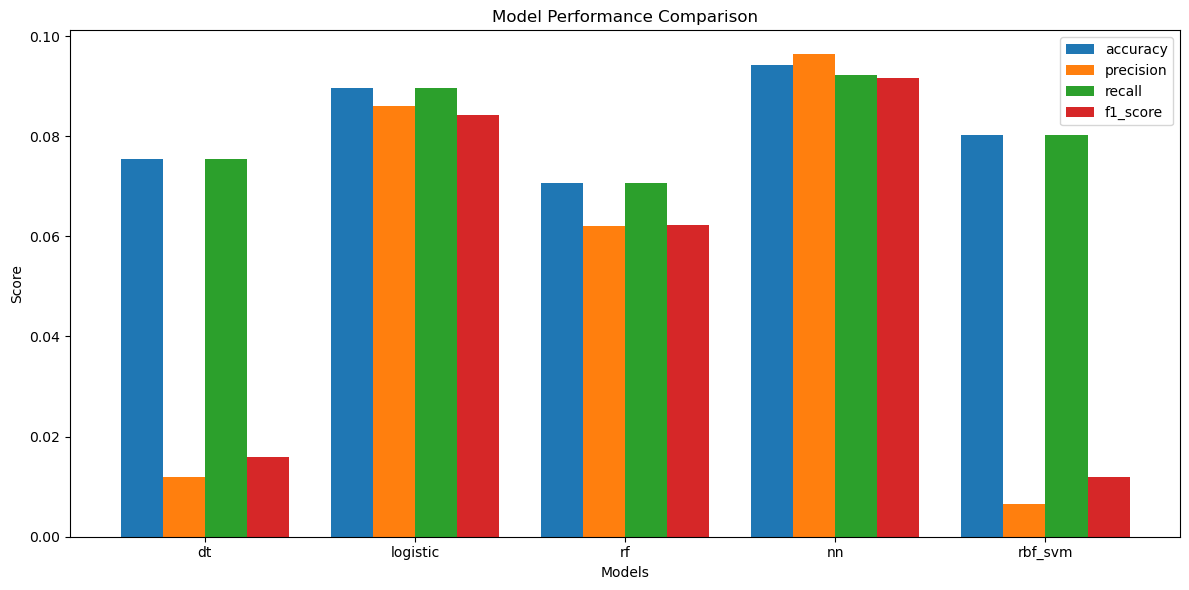

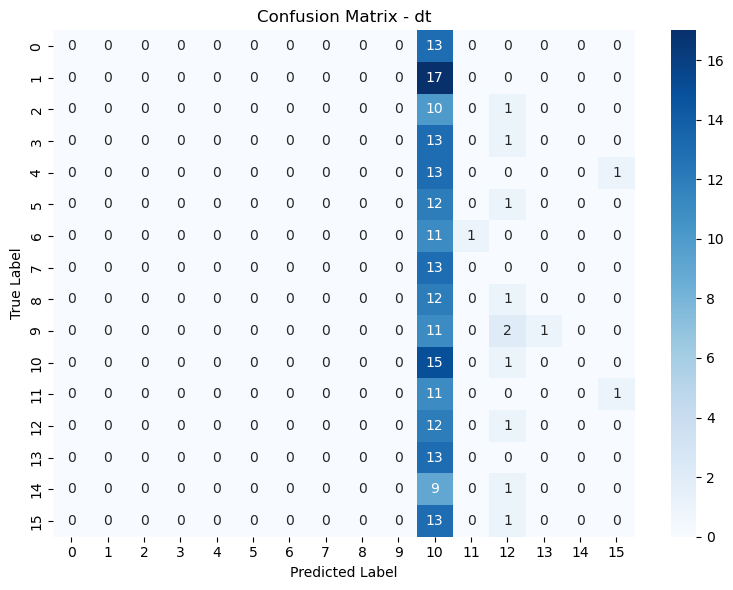

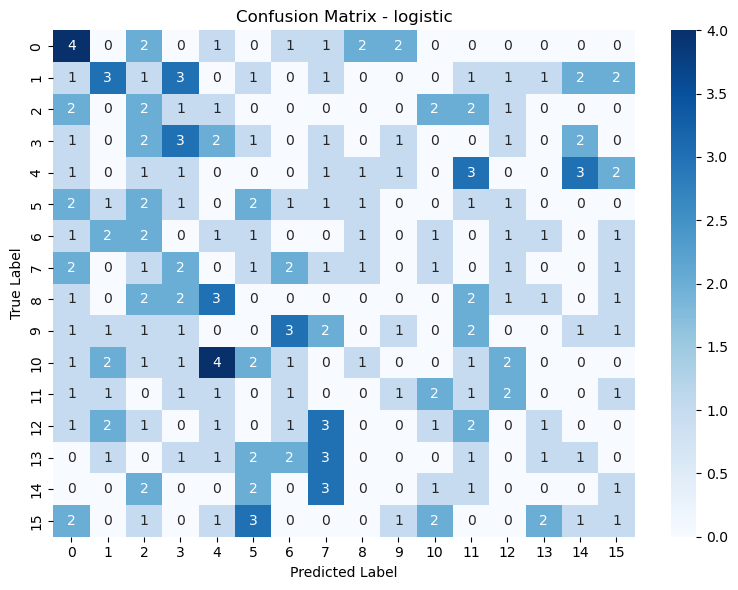

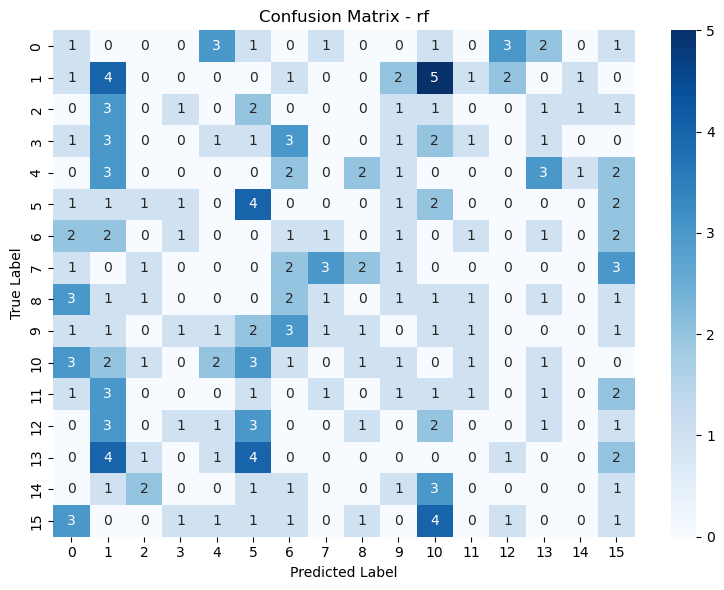

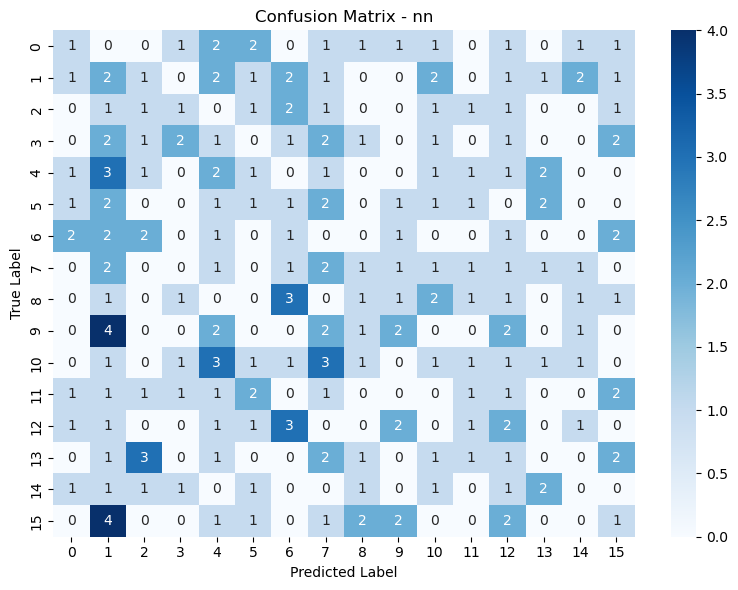

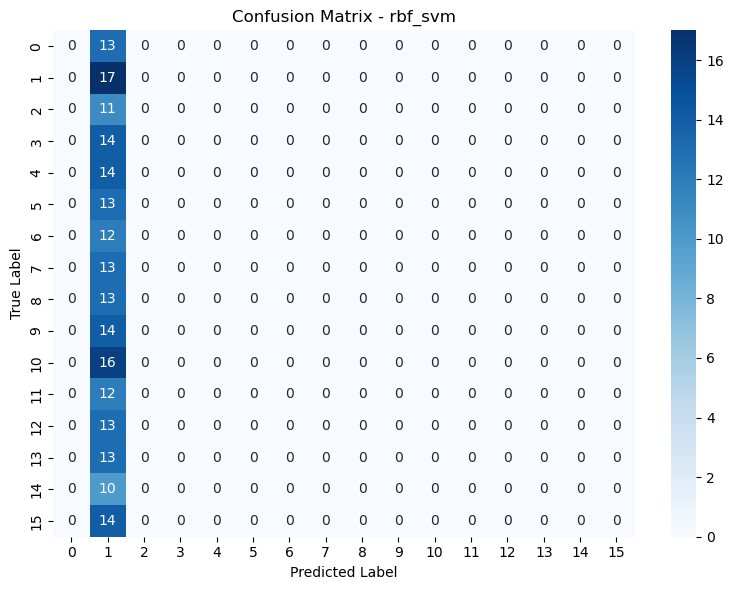

In [7]:
main('data/processed_race_results.csv', 'target')


Results may vary somewhat due to random preprocessing.